In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = (x_train.reshape(-1, 784).astype(np.float32)-127.5)/127.5
x_test = (x_test.reshape(-1, 784).astype(np.float32)-127.5)/127.5

In [4]:
def optimizer():
    return tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)

In [5]:
def creat_generator():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=256,input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(units=512))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(units=1024))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(units=784,activation='tanh'))

    model.compile(loss='binary_crossentropy',optimizer=optimizer(),metrics=['accuracy'])
    return model

In [6]:
g=creat_generator()

In [7]:
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [8]:
def creat_descriminator():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=1024,input_dim=784))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(units=512))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(units=256))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer=optimizer(),metrics=['accuracy'])
    return model

In [9]:
d=creat_descriminator()

In [10]:
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [11]:
def creat_gan(descriminator,generator):
    descriminator.trainable=False
    gan_input=tf.keras.layers.Input(shape=(100,))
    x=generator(gan_input)
    gan_output=descriminator(x)
    gan=tf.keras.models.Model(inputs=gan_input,outputs=gan_output)
    gan.compile(loss='binary_crossentropy',optimizer='adam')
    return gan

In [12]:
gan=creat_gan(d,g)

In [13]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [14]:
from tqdm import tqdm


In [15]:
def plot_generated_images(epoch,generator,examples=100,dim=(10,10),figsize=(10,10)):
    noise=np.random.normal(loc=0,scale=1,size=[examples,100])
    generated_images=generator.predict(noise)
    generated_images=generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i],interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('F:\\my project\\outputpic\\1\\gan_generated_image %d.png'% epoch)

In [16]:
def training(epochs=1,batch_size=128):
    batch_count=x_train.shape[0]/batch_size
    generator=creat_generator()
    discriminator=creat_descriminator()
    gan_=creat_gan(discriminator,generator)

    for e in range(1,epochs+1):
        #print('Epoch %d' %e)
        for i in range(batch_size):
            noise=np.random.normal(0,1,[batch_size,100])
            generated_image=generator.predict(noise)
            image_batch=x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            x=np.concatenate([image_batch,generated_image])
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.99
            discriminator.trainable=True
            discriminator.train_on_batch(x,y_dis)
            noise=np.random.normal(0,1,[batch_size,100])
            y_gan=np.ones(batch_size)
            discriminator.trainable=False
            gan_.train_on_batch(noise,y_gan)
        if e==0 or e%20 ==0:
            plot_generated_images(e,generator)

In [17]:
training(10,256)

8/8 [==============================] - 0s 6ms/step


In [23]:
exam=np.random.normal(0,1,size=[100,100])
pr=gan.predict(exam)

4/4 [==============================] - 0s 10ms/step


In [24]:
pr

array([[0.4516758 ],
       [0.50545126],
       [0.5004397 ],
       [0.4594836 ],
       [0.46809703],
       [0.4795263 ],
       [0.48224583],
       [0.4952748 ],
       [0.46807134],
       [0.49784636],
       [0.5001778 ],
       [0.4919107 ],
       [0.49346325],
       [0.49824724],
       [0.47484303],
       [0.5275543 ],
       [0.50103694],
       [0.5139052 ],
       [0.49245688],
       [0.46084082],
       [0.47715133],
       [0.46192077],
       [0.5045408 ],
       [0.47141397],
       [0.48840916],
       [0.4940218 ],
       [0.51482934],
       [0.46043313],
       [0.48319885],
       [0.49217865],
       [0.48460302],
       [0.48210612],
       [0.48789212],
       [0.48565307],
       [0.4930314 ],
       [0.48552057],
       [0.45561537],
       [0.476395  ],
       [0.5099497 ],
       [0.5047461 ],
       [0.47501126],
       [0.4730645 ],
       [0.48642492],
       [0.5053144 ],
       [0.49227127],
       [0.51941425],
       [0.5089746 ],
       [0.492

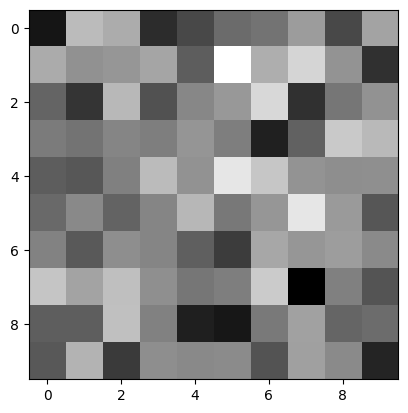

In [27]:
plt.imshow(pr.reshape(10,10),cmap='gray')